<a href="https://colab.research.google.com/github/Sakshar95/Sakshar95/blob/main/ABI%20HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings("ignore")

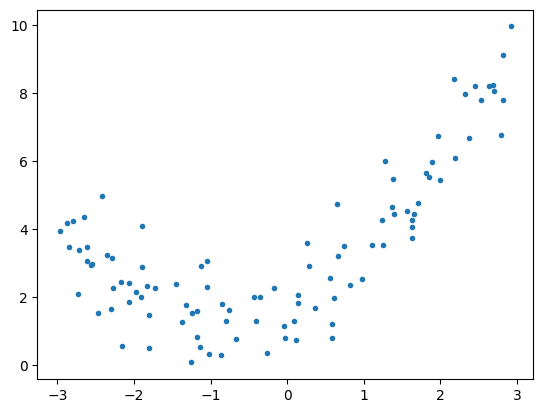

In [2]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X,y, ".")
plt.show()

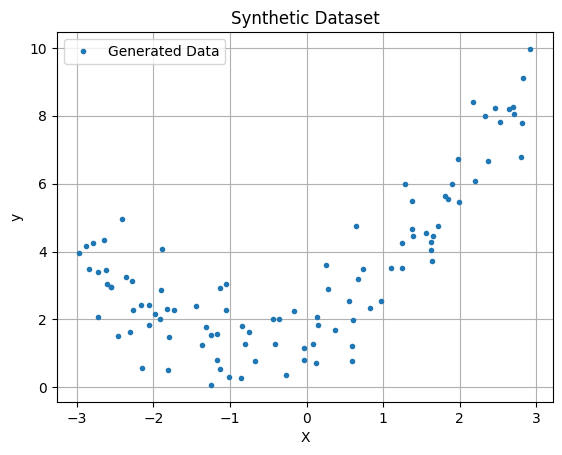

In [3]:
plt.plot(X, y, ".", label="Generated Data")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Synthetic Dataset")
plt.legend()
plt.grid(True)
plt.show()

#Task 1 – Bias and Variance

In [10]:
degrees = range(1, 11)
avg_test_mse_per_degree = []

for degree in degrees:
    test_mses = []
    for _ in range(100):
        # 80/20 train/test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        # Select 80% of training set again
        X_subtrain, _, y_subtrain, _ = train_test_split(X_train, y_train, test_size=0.2)

        # Polynomial transformation
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly_subtrain = poly.fit_transform(X_subtrain)
        X_poly_test = poly.transform(X_test)

        # Train and evaluate
        model = LinearRegression()
        model.fit(X_poly_subtrain, y_subtrain)
        y_pred = model.predict(X_poly_test)
        test_mses.append(mean_squared_error(y_test, y_pred))

    avg_test_mse_per_degree.append(np.mean(test_mses))


# Plotting

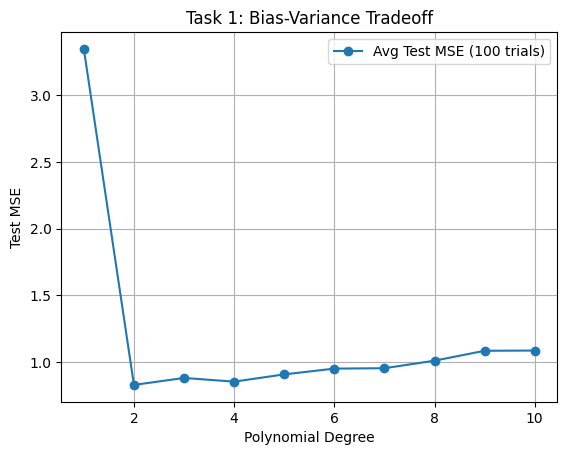

In [11]:
plt.plot(degrees, avg_test_mse_per_degree, marker='o', label='Avg Test MSE (100 trials)')
plt.xlabel("Polynomial Degree")
plt.ylabel("Test MSE")
plt.title("Task 1: Bias-Variance Tradeoff")
plt.grid(True)
plt.legend()
plt.show()

# Task 2 – Cross-Validation

In [59]:
all_val_mse_per_degree = []

for degree in range(1, 11):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    neg_mse_scores = cross_val_score(model, X_poly, y, scoring='neg_mean_squared_error', cv=5)
    all_val_mse_per_degree.append(-neg_mse_scores)


# Create boxplot

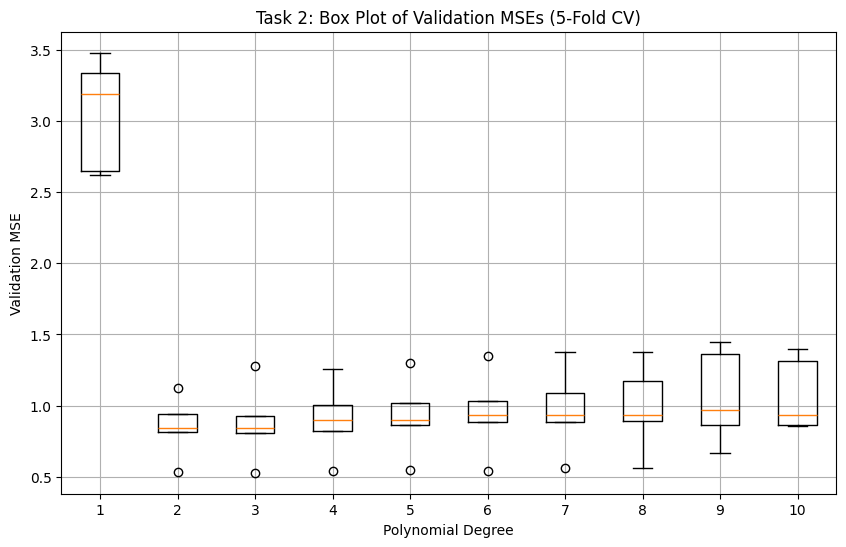

In [60]:

plt.figure(figsize=(10, 6))
plt.boxplot(all_val_mse_per_degree, labels=[str(d) for d in range(1, 11)])
plt.xlabel("Polynomial Degree")
plt.ylabel("Validation MSE")
plt.title("Task 2: Box Plot of Validation MSEs (5-Fold CV)")
plt.grid(True)
plt.show()

# Task 3 – LASSO Regression

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Use degree-10 polynomial

In [29]:
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# LASSO with alpha = 0.3

In [44]:
lasso = Lasso(alpha=0.3, max_iter=10000)
lasso.fit(X_poly_train, y_train)
y_pred_lasso = lasso.predict(X_poly_test)
rmse_lasso_fixed = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"LASSO RMSE (alpha=0.3): {rmse_lasso_fixed:.4f}")

LASSO RMSE (alpha=0.3): 2.1786


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.188e+00, tolerance: 4.337e-02
  model = cd_fast.enet_coordinate_descent(


# Grid Search for best alpha

In [47]:
param_grid = {'alpha': np.logspace(-4, 1, 30)}
grid_search_lasso = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search_lasso.fit(X_poly_train, y_train)

best_alpha = grid_search_lasso.best_params_['alpha']
print(f"Best alpha from Grid Search: {best_alpha}")

Best alpha from Grid Search: 10.0


# Evaluate LASSO with best alpha

In [48]:
lasso_best = Lasso(alpha=best_alpha, max_iter=10000)
lasso_best.fit(X_poly_train, y_train)
y_pred_best = lasso_best.predict(X_poly_test)
rmse_lasso_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"LASSO RMSE (best alpha): {rmse_lasso_best:.4f}")

LASSO RMSE (best alpha): 2.1368


# Task 4 – Elastic Net with Grid Search

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Use degree-10 polynomial

In [34]:
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Grid search over alpha and l1_ratio

In [49]:
param_grid_en = {
    'alpha': np.logspace(-4, 1, 10),
    'l1_ratio': np.linspace(0.1, 0.9, 9)
}

grid_search_en = GridSearchCV(
    ElasticNet(max_iter=10000),
    param_grid_en,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
grid_search_en.fit(X_poly_train, y_train)

best_params_en = grid_search_en.best_params_
print(f"Best ElasticNet alpha: {best_params_en['alpha']}, l1_ratio: {best_params_en['l1_ratio']}")


Best ElasticNet alpha: 10.0, l1_ratio: 0.9


# Evaluate best model

In [50]:
en_best = ElasticNet(alpha=best_params_en['alpha'], l1_ratio=best_params_en['l1_ratio'], max_iter=10000)
en_best.fit(X_poly_train, y_train)
y_pred_en = en_best.predict(X_poly_test)
rmse_en = np.sqrt(mean_squared_error(y_test, y_pred_en))
print(f"Elastic Net RMSE: {rmse_en:.4f}")

Elastic Net RMSE: 2.1368
